# Algoritmo de identificação entre carro e moto

## Objetivo
Esse notebook tem por objetivo demonstrar a implementação de um algoritmo de machine learning capaz de diferenciar entre carros e motos

## Procedimento
### Etapa 1: Instalação dos pré-requisitos
Rode os seguintes comandos de instalação de pacotes no terminal linux

In [ ]:
!pip install -Uqq fastai
!pip install -Uqq duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00


Agora, importaremos os metodos necessários para o funcionamento

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Etapa 2: Download das imagens
Realizaremos agora o download de uma unica imagem referente a um carro e uma moto para visualização da ideia inicial

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


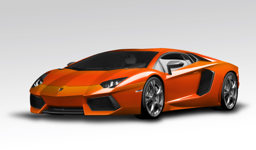

In [ ]:
# Download imagem Moto
download_url(search_images('car', max_images=1)[0], 'car.jpg', show_progress=True)
Image.open('car.jpg').to_thumb(256,256)

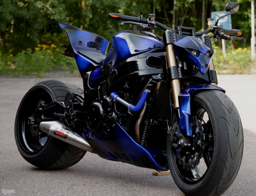

In [ ]:
# Download imagem Moto
download_url(search_images('motorcycle', max_images=1)[0], 'motorcycle.jpg', show_progress=True)
Image.open('motorcycle.jpg').to_thumb(256,256)

Agora precisamos de um repositório de dados de imagens que serão utilizados para treinamento do modelo, para isso executamos o seguinte código, nele é realizado o download de varias imagens de cada termo que estamos procurando e salvando-as no diretorio "carro_ou_moto"

In [ ]:
searches = 'car','motorcycle'
path = Path('car_or_motorcycle')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} old photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} modern photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

### Etapa 3: Treino do modelo

Vamos iniciar validando as fotos baixadas em busca de falhas e ja descartando as imagens defeituosas(Os critérios de busca são alguns dados como imagem corrompida, extensão invalida e etc, para mais detalhes consultar a documentação da biblioteca), para isso executamos a seguinte função:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"Foram encontrados {len(failed)} falhas de imagens e automaticamente eliminadas.")

Foram encontrados 19 falhas de imagens e automaticamente eliminadas.


Utilizaremos agora dos DataLoaders(recursos utilizados para treino e validação de algoritmos) para realizar o treino do modelo, na biblioteca do fastai temos a função DataBlock que é responsável por isso

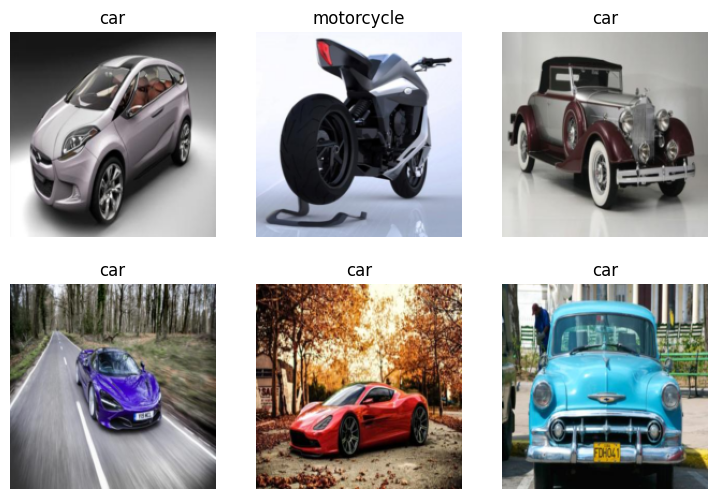

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Após o treino, podemos visualizar as métricas alcançadas com o treino vendo o progresso e a taxa de acerto do modelo, para isso utilizamos do seguinte codigo, nesse exemplo usaremos o modelo da resnet18, que por sua vez é amplamente utilizado e conhecimento

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 307MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.743146,0.061976,0.020000,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.077952,0.052917,0.030000,01:27
1,0.051329,0.030179,0.010000,01:36
2,0.041257,0.029929,0.010000,01:43


### Etapa 4: Utilização do modelo para previsão de imagens

Agora que nosso modelo está treinado, basta utilizarmos imagens nele para receber a resposta sobre ser um carro ou moto, para isso, troque o campo 'carro.jpg' para o nome do arquivo de imagem que deseja analisar, ao executar o codigo obterá o retorno da imagem e a definição se ela é carro ou moto

Também é possível verificar a capacidade do modelo em identificar os dois tipos de veiculos através da nossa aplicação web em gradio no [Link em questão](https://huggingface.co/spaces/fastaioncampus/carro-ou-moto)

Essa imagem é: car.
Com a probabilidade de acerto de: 0.9994


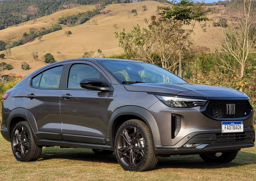

In [ ]:
is_car,_,probs = learn.predict(PILImage.create('carro.jpg'))

print(f"Essa imagem é: {is_car}.")
print(f"Com a probabilidade de acerto de: {probs[0]:.4f}")

Image.open('carro.jpg').to_thumb(256,256)

Com isso é possivel concluir que o modelo pré-treinado utilizado está funcionando corretamente e a inferencia devidamente realizada

| Versão    | Data | Descrição                 |         Autor |
|-----------|------|---------------------------|---------------|
|<center>0.1|11/09 |Criação da página          |Arthur Henrique|
|<center>0.2|20/09 |Correção do funcionamento do codigo  |Arthur Henrique|
|<center>0.3|20/09 |Adição da aplicação web gradio  |Arthur Henrique|